In [47]:
import os

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Plots for static objectives

In [2]:
solutions_7 = pd.DataFrame()
solutions_8 = pd.DataFrame()

for s in os.listdir('plotdata/Static objectives 7 enemies trained'):
    if s.endswith('.csv'):
        df = pd.read_csv(f'plotdata/Static objectives 7 enemies trained/{s}')
        solutions_7 = pd.concat([solutions_7, df])
        
for s in os.listdir('plotdata/Static objectives 8 enemies trained'):
    if s.endswith('.csv'):
        df = pd.read_csv(f'plotdata/Static objectives 8 enemies trained/{s}')
        solutions_8 = pd.concat([solutions_8, df])
    
solutions_7 = solutions_7.reset_index(drop=True)
solutions_8 = solutions_8.reset_index(drop=True)

In [3]:
f = ['obj_hard', 'obj_medium', 'obj_easy']

# Aggregating the mean
solutions_7['Average Objective Fitness'] = solutions_7[f].mean(axis=1)
solutions_8['Average Objective Fitness'] = solutions_8[f].mean(axis=1)

# Aggregating the max
solutions_7_max = solutions_7.groupby('n_evals').max().rename(columns={'Average Objective Fitness': 'Maximum Objective Fitness'})
solutions_8_max = solutions_8.groupby('n_evals').max().rename(columns={'Average Objective Fitness': 'Maximum Objective Fitness'})

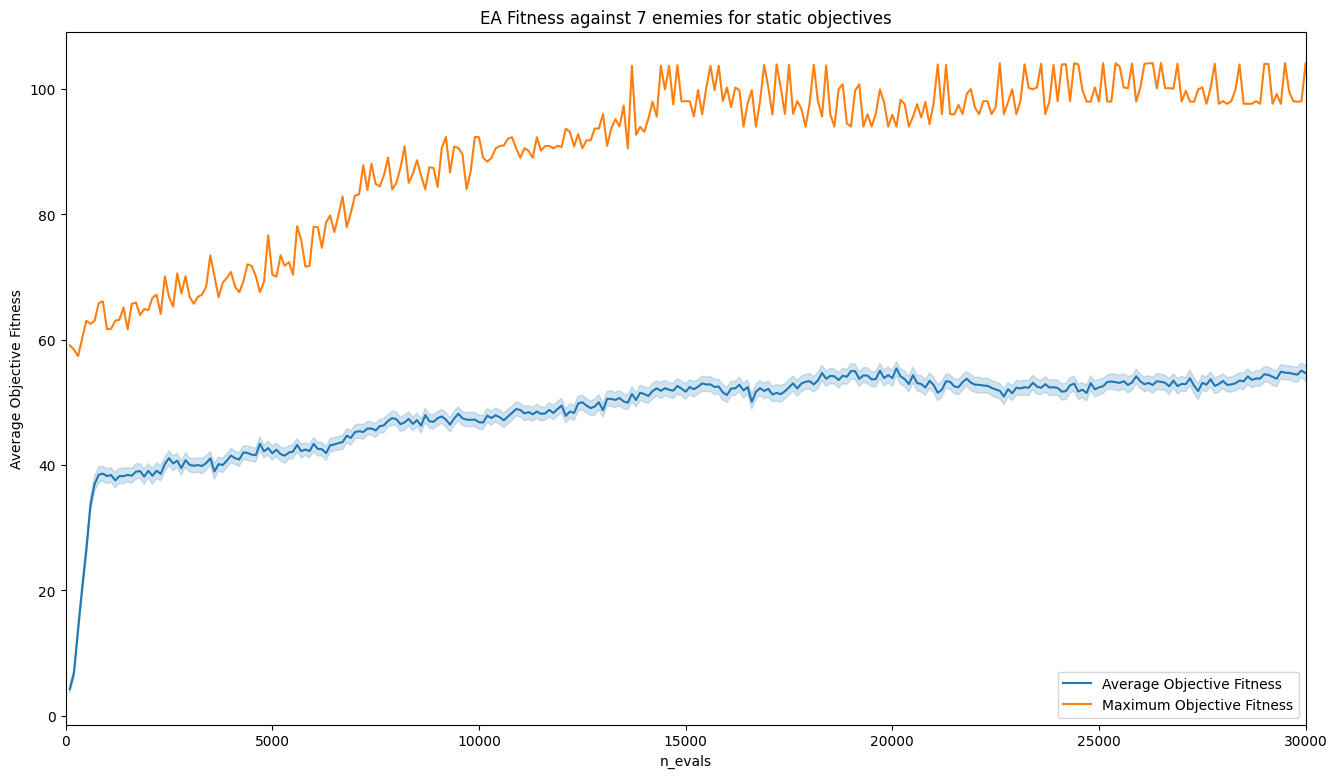

In [4]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(16, 9))

# Plot mean and std
sns.lineplot(data=solutions_7, x='n_evals', y='Average Objective Fitness', 
             ax=ax, label='Average Objective Fitness')

# Plot max
sns.lineplot(data=solutions_7_max, x='n_evals', y='Maximum Objective Fitness', 
             ax=ax, label='Maximum Objective Fitness')

# Plot legend
ax.legend(loc=4)
ax.set_title('EA Fitness against 7 enemies for static objectives')

# Show
plt.xlim(0, 30000)
plt.show();

# Plots for dynamic objectives

In [118]:
# Dynamic objectives
# N_eval = N_iter * 200

fitness_mean_grouped = []
fitness_max_grouped = []
fitness_std_grouped = []

for d in os.listdir('plotdata/Dynamic objectives'):
    if d == '1-4':
        d = '1-4/final_generalist_assignment'
        
    for f in os.listdir(f'plotdata/Dynamic objectives/{d}'):
        if f.endswith('.csv') and f.startswith('dynamic_objectives') and 'secondary' not in f and not f.startswith('dynamic_objectives_5'):
            df = pd.read_csv(f'plotdata/Dynamic objectives/{d}/{f}')
            
            fitness_mean = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).mean().reset_index()
            fitness_mean['n_eval'] = 200 * fitness_mean['n_iter'] + 20 * fitness_mean['n_gens']
            fitness_mean = fitness_mean.set_index('n_eval')['mean_obj']
            fitness_mean_grouped.append(fitness_mean)

            fitness_max = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).max().reset_index().rename(columns={'mean_obj': 'max_obj'})
            fitness_max['n_eval'] = 200 * fitness_max['n_iter'] + 20 * fitness_max['n_gens']
            fitness_max = fitness_max.set_index('n_eval')['max_obj']
            fitness_max_grouped.append(fitness_max)

            fitness_std = df[['n_iter', 'n_gens', 'mean_obj']].groupby(['n_iter', 'n_gens']).std().reset_index().rename(columns={'mean_obj': 'std_obj'})
            fitness_std['n_eval'] = 200 * fitness_std['n_iter'] + 20 * fitness_std['n_gens']
            fitness_std = fitness_std.set_index('n_eval')['std_obj']
            fitness_std_grouped.append(fitness_std)

fitness_mean_agg = pd.concat(fitness_mean_grouped).groupby('n_eval').mean()
fitness_max_agg = pd.concat(fitness_max_grouped).groupby('n_eval').mean()
fitness_std_agg = pd.concat(fitness_std_grouped).groupby('n_eval').mean()

In [116]:
max_beaten_dynamic = []
for d in os.listdir('plotdata/Dynamic objectives'):
    if d == '1-4':
        d = '1-4/final_generalist_assignment'
        
    for f in os.listdir(f'plotdata/Dynamic objectives/{d}'):
        if f.endswith('.csv') and f.startswith('max'):
            df = pd.read_csv(f'plotdata/Dynamic objectives/{d}/{f}', index_col=0).groupby('n_iter').agg('max')
            max_beaten_dynamic.append(df)

max_beaten_dynamic = pd.concat(max_beaten_dynamic).reset_index()
max_beaten_dynamic['max_enemies_beaten_roll'] = max_beaten_dynamic['max_enemies_beaten'].rolling(50).mean()
max_beaten_dynamic.head()

,n_iter,n_evals,max_enemies_beaten,max_enemies_beaten_roll
0,0,0,3,NaN
1,1,200,3,NaN
2,2,400,4,NaN
3,4,800,4,NaN
4,5,1000,4,NaN


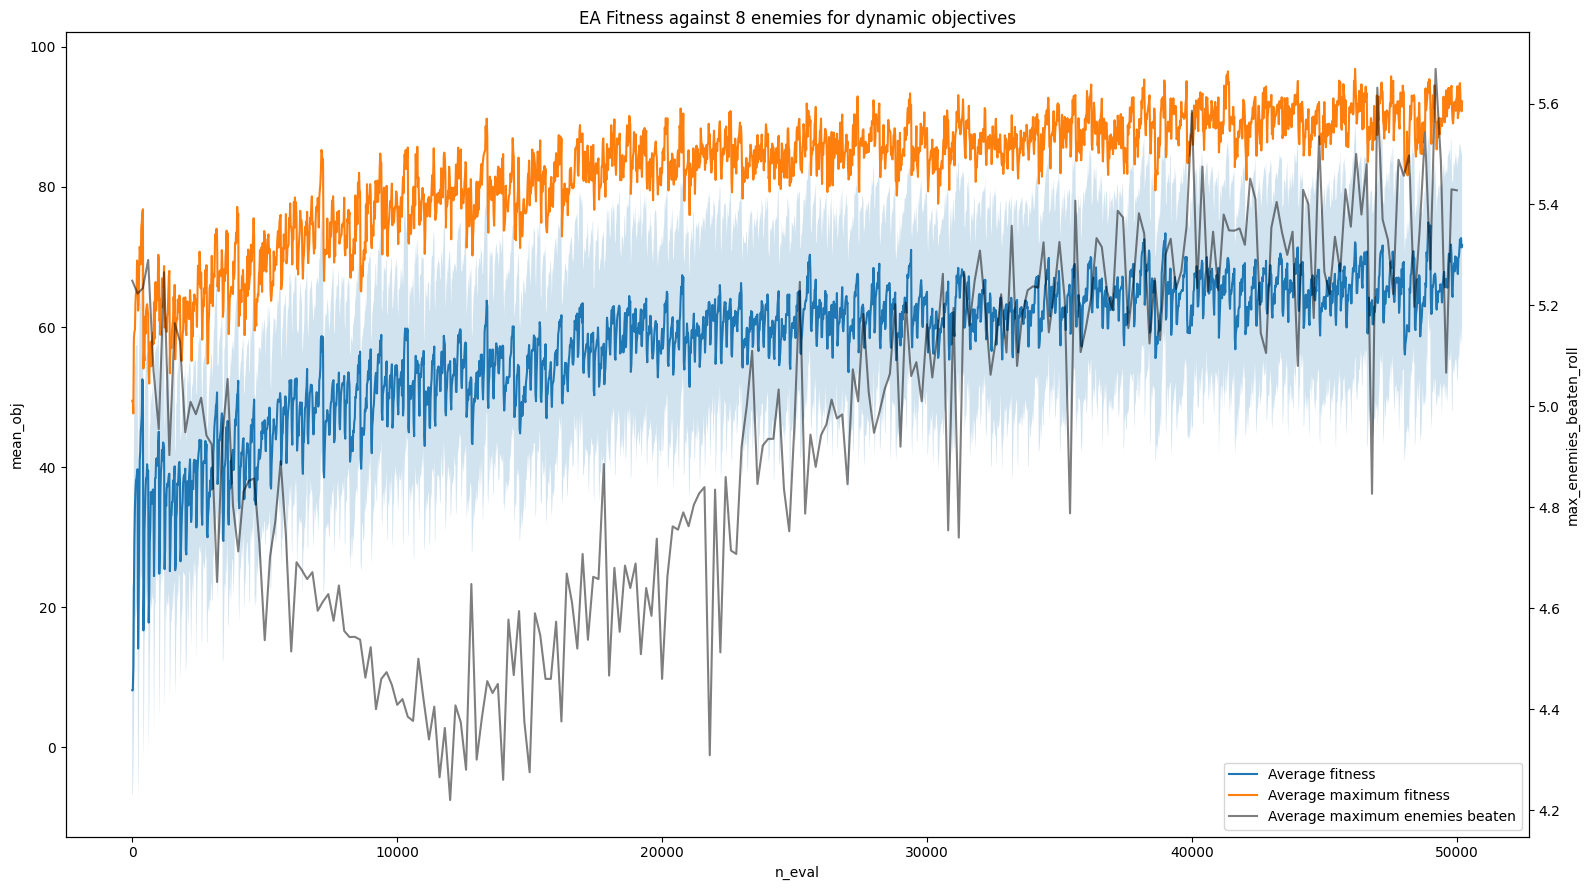

In [110]:
fig, ax = plt.subplots(figsize=(16, 9))

# Plot average and max
sns.lineplot(fitness_mean_agg,
             ax=ax, label='Average fitness')
sns.lineplot(fitness_max_agg,
             ax=ax, label='Average maximum fitness')

ax.fill_between(fitness_mean_agg.index, 
                fitness_mean_agg - fitness_std_agg, 
                fitness_mean_agg + fitness_std_agg, 
                alpha=0.2)

# Plot max enemies beaten
ax2 = ax.twinx()
sns.lineplot(data=max_beaten_dynamic, x='n_evals', y='max_enemies_beaten_roll',
             ax=ax2, label='Average maximum enemies beaten', legend=None,
             color='black', errorbar=None, alpha=0.5)

# Plot legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines+lines2, labels+labels2, loc=4)
ax.set_title('EA Fitness against 8 enemies for dynamic objectives')

# Show
fig.tight_layout()
plt.show();

# Boxplots

In [120]:
import numpy as np
import ast

algorithm_gain = []

## Have to import random search separately as it needs to be parsed first
batch_gain = []
random_solutions = []
for f in os.listdir('plotdata/boxplotdata/random_search_performance_generalist'):
    data = pd.read_csv(f'plotdata/boxplotdata/random_search_performance_generalist/{f}', index_col=0)
    random_solutions.append(data)
    
random_solutions = pd.concat(random_solutions)
# Group in batches of 50 000
for k, g in random_solutions.groupby(np.arange(len(random_solutions))//50000):
    data = g.copy()
    
    # Lists in dataframe are stored as string, so first convert back to list
    data['enemy lives'] = data['enemy lives'].apply(lambda x: ast.literal_eval(x))
    data['player lives'] = data['player lives'].apply(lambda x: ast.literal_eval(x))
    
    # Make NP array of lists for substraction
    data[['enemy lives', 'player lives']] = data[['enemy lives', 'player lives']].map(np.array)
    data['individual gain'] = data['player lives'] - data['enemy lives']
    data['individual gain'] = data['individual gain'].apply(lambda x: sum(x))
    
    # Get the best performing solution per batch
    best_batch_gain = data[data['enemies beaten'] == data['enemies beaten'].max()].nlargest(1, 'individual gain')
    batch_gain.append(best_batch_gain)
    
random = pd.concat(batch_gain)[['enemies beaten', 'individual gain']].rename(columns={'enemies beaten': 'enemies_beaten', 'individual gain': 'ind_gain'})
random['file'] = 'random_search'
algorithm_gain.append(random)

# Afterwards, load in the rest
for f in os.listdir('plotdata/boxplotdata/'):
    data = pd.read_csv(f'plotdata/boxplotdata/{f}', index_col=0)
    
    # Set file name so we can differentiate in the boxplot, can change name later
    data['file'] = f
    algorithm_gain.append(data)
    
algorithm_gain = pd.concat(algorithm_gain)
algorithm_gain.head()

PermissionError: [Errno 13] Permission denied: 'plotdata/boxplotdata/random_search_performance_generalist'

<Axes: xlabel='file', ylabel='ind_gain'>

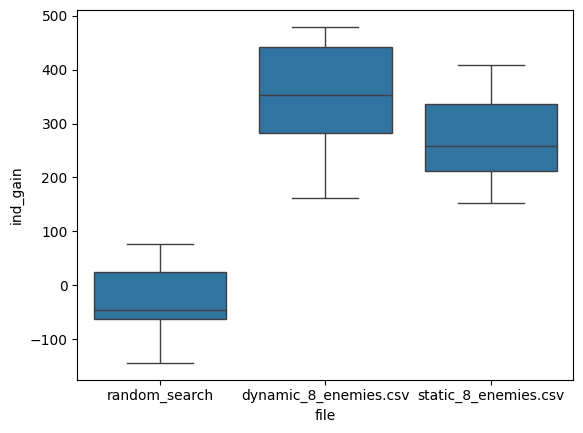

In [115]:
sns.boxplot(data=algorithm_gain, x='file', y='ind_gain')